# Search Umbra SAR Archive

Archive doesn't require authentication
https://docs.canopy.umbra.space/docs/archive-catalog-searching-via-stac-api

rate limited to 2 Requests / Second by request IP Address.
https://docs.canopy.umbra.space/docs/rate-limiting#archive-catalog-rate-limits


In [1]:
import geopandas as gpd
import pystac_client
import os 

In [2]:
# Basic search, 10 most recent acquistions

# NOTE: trailing slash seems critical, else get 'no healthy upstream' error
stac_api_url = "https://api.canopy.umbra.space/archive/"
catalog = pystac_client.Client.open(stac_api_url)

time_range = ["2020-01-01", None]
intersect_geometry = None

stac_search = catalog.search(
    max_items=10,
    collections=["umbra-sar"], 
    intersects=intersect_geometry, 
    datetime=time_range,
)

items = stac_search.item_collection()
gf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
len(gf)

10

In [3]:
# Search for acquitiions in public data program
stac_api_url = "https://api.canopy.umbra.space/archive/"
catalog = pystac_client.Client.open(stac_api_url)

cql2filter = {
    "op": "=",
    "args": [
      {
        "property": "umbra:open-data-catalog"
      },
      True
    ]
  }

#limit_results=10000 #APIError: upstream request timeout
#limit_results=5000 #APIError: upstream request timeout
limit_results=2000 #works
#limit_results=1000 #works

stac_search = catalog.search(
    bbox='-124.84, 24.39, -66.88, 49.38',
    filter=cql2filter,
    max_items=limit_results,
    #NOTE: seems this must be set to>= max_items, else 'Unauthorized'
    limit=limit_results,
)

items = stac_search.item_collection()
gf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
len(gf)

1372

In [4]:
# Only thumbnails in assets!
i = items[-1]
i.assets['thumbnail'].href

'https://api.canopy.umbra.space/archive/thumbnail/dce419d0-fb28-41cc-9dae-5221aab83f3e'

In [5]:
# Search for all acquisitions in WA State

aoi = gpd.read_file('https://raw.githubusercontent.com/unitedstates/districts/refs/heads/gh-pages/states/WA/shape.geojson')
aoi.explore()

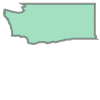

In [6]:
aoi.geometry.iloc[0]

In [7]:
# Search for acquitiions in public data program
stac_api_url = "https://api.canopy.umbra.space/archive/"
catalog = pystac_client.Client.open(stac_api_url)

cql2filter = {
    "op": "=",
    "args": [
      {
        "property": "umbra:open-data-catalog"
      },
      True
    ]
  }

limit_results=2000 

stac_search = catalog.search(
    #filter=cql2filter,
    max_items=limit_results,
    limit=limit_results,
    intersects=aoi.geometry.iloc[0], 
)

items = stac_search.item_collection()
gf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
len(gf)

68

In [8]:
gf.explore(column='umbra:open-data-catalog', cmap='plasma', popup=True)

In [9]:
from IPython.display import Image
def show_thumbnail(row):
    item = items[row.name]
    print(item.id)
    display(Image(url=item.assets['thumbnail'].href))

# Thumbnails are public even for non-open data
show_thumbnail(gf.iloc[0])
show_thumbnail(gf.iloc[30])

79f710dc-18a0-4eb0-bd57-cd812b19e8a8


ae335b6e-23ed-4d89-a679-ce74552c0cc2
